In [1]:
import keras,os
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import warnings 
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = r"/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/train"
test_dir = r"/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test"

train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15,rotation_range=20,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,vertical_flip=True)
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = train_dir,target_size = (128,128),seed=1,
                                                   class_mode = 'categorical',subset = 'training',batch_size = 32)

valid_dataset = train_datagen.flow_from_directory(directory = train_dir,target_size = (128,128),seed=1,
                                                   class_mode = 'categorical',subset = 'validation',batch_size = 32)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,target_size = (128,128),seed=1,
                                                class_mode = 'categorical',batch_size = 16)

Found 4355 images belonging to 4 classes.
Found 766 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
import os
from distutils.dir_util import copy_tree, remove_tree

base_dir = r"/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset"
root_dir = "./"
test_dir = os.path.join(base_dir, "train")
train_dir = os.path.join(base_dir, "test")
work_dir = os.path.join(root_dir, "dataset/")

if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'NonDemented']


In [5]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

In [6]:
zoomrange = [.9, 1.0]
brightness = [0.7, 1.3]

work_dr = ImageDataGenerator(rescale = 1./255, brightness_range=brightness, zoom_range=zoomrange, 
                             data_format="channels_last", fill_mode="constant", horizontal_flip=True)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=(128,128), 
                                             batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [7]:
train_data_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [8]:
train_data, train_labels = next(train_data_gen)

In [9]:
print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400, 4)


In [10]:
valid_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

Found 190 images belonging to 4 classes.


In [11]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 128 * 128 * 3), train_labels)
train_data = train_data.reshape(-1, 128, 128, 3)
print(train_data.shape, train_labels.shape)

(12800, 128, 128, 3) (12800, 4)


In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.15, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [13]:
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical

classifier = Sequential()

classifier.add(Conv2D(32, (2, 2), input_shape=(128, 128, 3)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(32, (2, 2)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(64, (2, 2)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten())

classifier.add(Dense(64))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(4))
classifier.add(Activation('softmax'))

In [14]:
from tensorflow.keras.optimizers import Adam
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc')]
classifier.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 127, 127, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       921,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 934,724 (3.57 MB)

 Trainable params: 934,724 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
EPOCHS = 100
history1 = classifier.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.8325 - loss: 0.3354 - val_acc: 0.8764 - val_loss: 0.3031
Epoch 2/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8542 - loss: 0.3092 - val_acc: 0.8686 - val_loss: 0.3334
Epoch 3/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8463 - loss: 0.3066 - val_acc: 0.8722 - val_loss: 0.3307
Epoch 4/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8513 - loss: 0.3021 - val_acc: 0.8842 - val_loss: 0.3020
Epoch 5/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8519 - loss: 0.3118 - val_acc: 0.8819 - val_loss: 0.3047
Epoch 6/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8667 - loss: 0.2796 - val_acc: 0.8805 - val_loss: 0.3217
Epoch 7/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8593 - loss: 0.2895 - val_acc: 0.8722 - val_loss: 0.3404
Epoch 8/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8565 - loss: 0.2855 - val_acc: 0.8796 - val_loss: 0.3145
Epoch 9/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


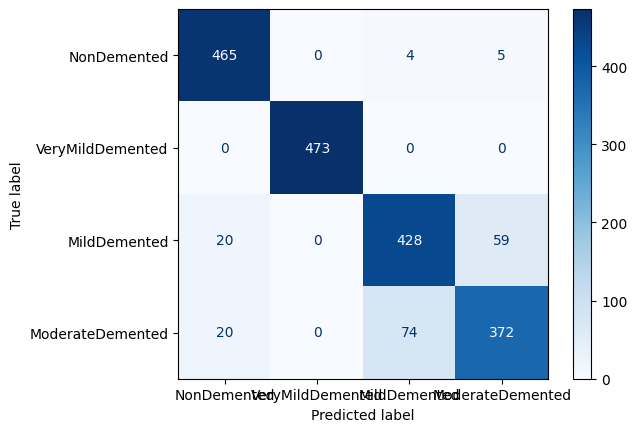

/kaggle/working/sine_wave_example.png

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Make predictions
preds = classifier.predict(test_data)
preds_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, preds_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

# Display the confusion matrix
disp.plot(cmap=plt.cm.Blues)
from IPython.display import FileLink

# Save the plot as a PNG image
output_file = "sine_wave_example.png"  # Save it in the current directory
plt.savefig(output_file, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Create a download link to the saved image
FileLink(output_file)

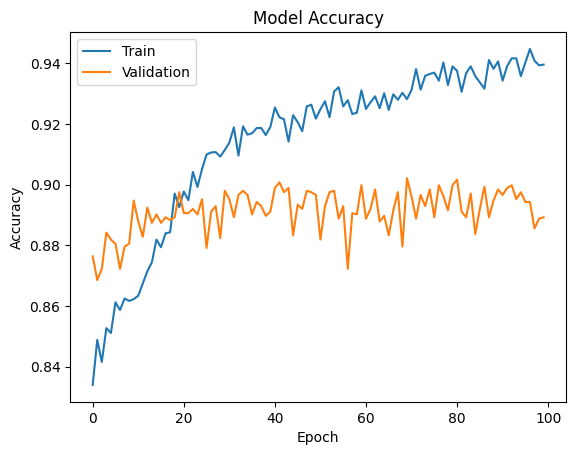

/kaggle/working/sine_wave_example.png

In [21]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Save the plot as a PNG image
output_file = "sine_wave_example.png"  # Save it in the current directory
plt.savefig(output_file, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Create a download link to the saved image
FileLink(output_file)

In [22]:
classifier.save('cnn_alzheimers_60.h5')
print("Model saved as cnn_alzheimers_60.h5")

Model saved as cnn_alzheimers_60.h5


In [23]:
import keras
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
model = load_model('cnn_alzheimers_60.h5')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

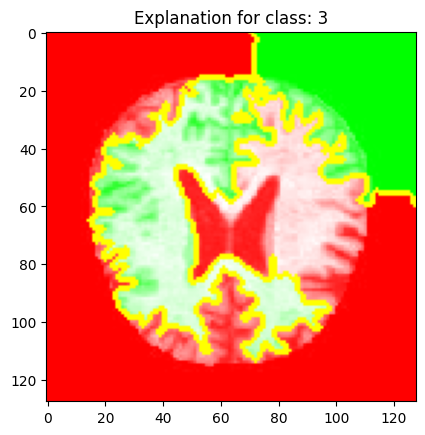

/kaggle/working/sine_wave_example.png

In [25]:
# Define a function to preprocess the image
def preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.inception_v3.preprocess_input(img_array_expanded_dims)

image_path = r"/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/VeryMildDemented/27 (11).jpg"
preprocessed_img = preprocess_image(image_path)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(preprocessed_img[0].astype('double'), 
                                         model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('Explanation for class: {}'.format(explanation.top_labels[0]))
# Save the plot as a PNG image
output_file = "sine_wave_example.png"  # Save it in the current directory
plt.savefig(output_file, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Create a download link to the saved image
FileLink(output_file)

In [27]:
from tensorflow.keras.utils import img_to_array,load_img
def read_image(file_path):
    print("[INFO] loading and preprocessing image…") 
    image = load_img(file_path, target_size=(128,128,1)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0) 
    return image

In [28]:
def predict_proba(number):
    return [number[0],1-number[0]]

In [29]:
import time
def test_single_image(path):
    labels = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = model.predict(images) 
    preds = predict_proba(bt_prediction)
    for idx, label, x in zip(range(0,6), labels , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, label, np.round(x*100,2) ))
    
    return load_img(path)

[INFO] loading and preprocessing image…
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
ID: 0, Label: MildDemented 0.0%
ID: 1, Label: ModerateDemented 0.0%
ID: 2, Label: NonDemented 0.0%
ID: 3, Label: VeryMildDemented 100.0%


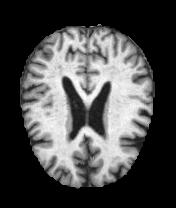

In [30]:
path = r"/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/VeryMildDemented/27 (11).jpg"
test_single_image(path)

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

predictions = classifier.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(test_labels, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=CLASSES)
print(report)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                  precision    recall  f1-score   support

     NonDemented       0.92      0.98      0.95       474
VeryMildDemented       1.00      1.00      1.00       473
    MildDemented       0.85      0.84      0.85       507
ModerateDemented       0.85      0.80      0.82       466

        accuracy                           0.91      1920
       macro avg       0.90      0.91      0.90      1920
    weighted avg       0.90      0.91      0.90      1920

